In [1]:
!pip -q install git+https://github.com/rwightman/pytorch-image-models.git
!pip -q install GPUtil

In [2]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [3]:
def free_gpu_cache():
    print("Initial GPU Usage")
    GPUtil.showUtilization()                            
    torch.cuda.empty_cache()
    print("GPU Usage after emptying the cache")
    GPUtil.showUtilization()

In [4]:
# import wandb
# wandb.login(key='b31d72ff900ab3435ad236aebfff69b74fe2e4b4')
# run = wandb.init(
#     # Set the project where this run will be logged
#     project="Real_or_fake",)

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image, ImageChops, ImageEnhance
import os
from glob import glob
from tqdm.notebook import tqdm, trange


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchinfo import summary

from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.callback.wandb import *


from sklearn.model_selection import train_test_split

import warnings 
import albumentations
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
#Dataset Preparation
image_size = (448, 448)

def convert_to_ela_image(image, quality=90):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return Image.fromarray(np.array(ela_image))





### Fake

(28, 28)
(448, 448)


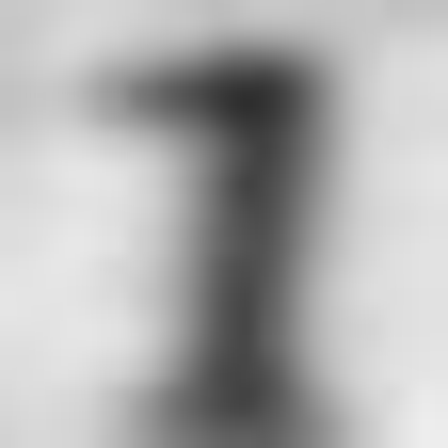

In [7]:
real_image_path = '/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (100).jpg'
img=Image.open(real_image_path)
print(img.size)
new_img = img.resize(image_size)
print(new_img.size)
new_img

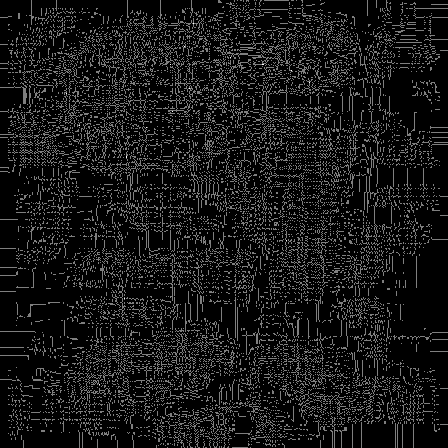

In [8]:
convert_to_ela_image(new_img)


## Real

(28, 28)
(448, 448)


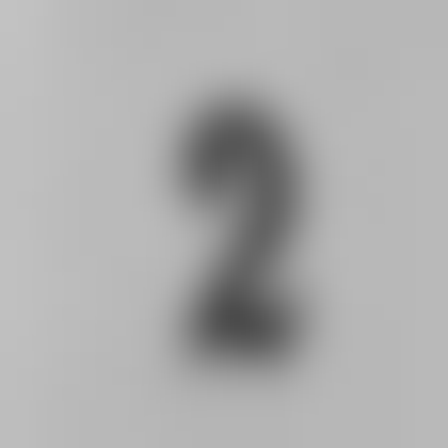

In [9]:
real_image_path = '/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (100).png'
img=Image.open(real_image_path)
print(img.size)
new_img = img.resize(image_size)
print(new_img.size)
new_img

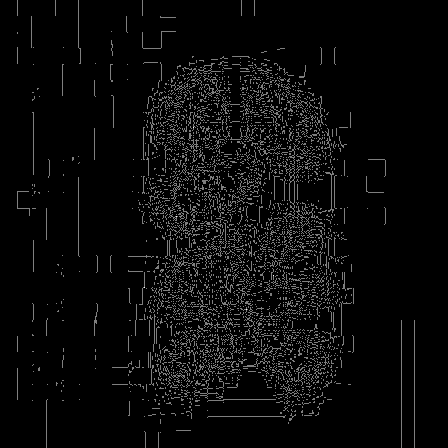

In [10]:
convert_to_ela_image(new_img)


In [11]:
label_fake=os.listdir('/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0')
label_real=os.listdir('/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1')
len(label_fake),len(label_real)

(487, 514)

In [12]:
df_train = pd.DataFrame({"filename":[],"label":[]})

old_path = '/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/'
for path in tqdm(label_fake):
    df_train.loc[len(df_train)]=(old_path+path,0)
    
old_path = '/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/'
for path in tqdm(label_real):
    df_train.loc[len(df_train)]=(old_path+path,1)
df_train

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

,filename,label
0,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (71).jpg,0
1,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (341).jpg,0
2,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (96).jpg,0
3,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (362).jpg,0
4,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (6).png,0
...,...,...
996,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (116).png,1
997,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (344).jpg,1
998,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (122).jpg,1
999,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (184).jpg,1


In [13]:
df_test = pd.read_csv('/kaggle/input/hackathon-online-realfakenumbers/sample_submission.csv')
df_test['img_name'] = df_test['img_name'].apply(lambda x : "/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/" + x)
tstpng = df_test.copy()
tstpng

,img_name,code
0,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_0.png,0.0
1,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_1.png,0.0
2,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_2.png,1.0
3,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_3.png,NaN
4,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_4.png,NaN
...,...,...
1005,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_1005.png,NaN
1006,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_1006.png,NaN
1007,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_1007.png,NaN
1008,/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/new_name_1008.png,NaN


In [14]:
df_train['fold'] =-1
fold = 0
for i in range(len(df_train)):
    if i!=0 :
            fold += 1
    if fold ==10 :
        fold =0
    df_train.loc[i,'fold'] = fold
#random shuffle   
df_train=df_train.sample(frac=1)
df_train
        

,filename,label,fold
713,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (114).png,1,3
442,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (43).jpg,0,2
64,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (49).png,0,4
722,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (2).png,1,2
511,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (41).jpg,1,1
...,...,...,...
278,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (74).jpg,0,8
270,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (6).jpg,0,0
527,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (96).png,1,7
576,/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (389).jpg,1,6


In [15]:
!mkdir image_test

In [16]:
image_size = 448
batch = 8
model_name =  "eva02_base_patch14_448.mim_in22k_ft_in22k_in1k"

In [17]:
def convert_to_ela_image(image, quality=90):
    temp_filename = f'/kaggle/working/image_test/temp_file_{image[0].sum()}.jpg'
    ela_filename = f'/kaggle/working/image_test/temp_ela{image[0].sum()}.png'
    image = Image.fromarray(image)
    image=image.resize((image_size,image_size))
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return (np.array(ela_image))

In [18]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
from albumentations import ImageOnlyTransform

class AutoELA(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)

    def apply(self, img, **params):
        return convert_to_ela_image(img,90)
        
    def get_transform_init_args_names(self):
        return ()

In [19]:
def get_train_aug(): return albumentations.Compose([
#             AutoELA(),
            albumentations.Resize(always_apply=False, p=1.0, height=image_size, width=image_size, interpolation=0),
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.Rotate(limit=(-25, 25)),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-25, 25), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
#             albumentations.HueSaturationValue(
#                 hue_shift_limit=0.2, 
#                 sat_shift_limit=0.2, 
#                 val_shift_limit=0.2, 
#                 p=0.5
#             ),
#             albumentations.RandomBrightnessContrast(
#                 brightness_limit=(-0.1,0.1), 
#                 contrast_limit=(-0.1, 0.1), 
#                 p=0.5
#             ),
#             albumentations.RandomGamma(),
#             albumentations.ToGray(always_apply=False, p=1.0)
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.)



def get_valid_aug(): return albumentations.Compose([
#             AutoELA(),
            albumentations.Resize(always_apply=False, p=1.0, height=image_size, width=image_size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
#             albumentations.ToGray(always_apply=False, p=1.0),

             
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [20]:
def get_data(fold=0,image_size=image_size):
    return DataBlock(blocks=(ImageBlock,CategoryBlock),
                       get_x=ColReader(0),
                       get_y=ColReader(1),
                       splitter=IndexSplitter(df_train[df_train['fold'] == fold].index),
                       item_tfms = item_tfms,
                       batch_tfms = batch_tfms
                      ).dataloaders(df_train, bs=batch)

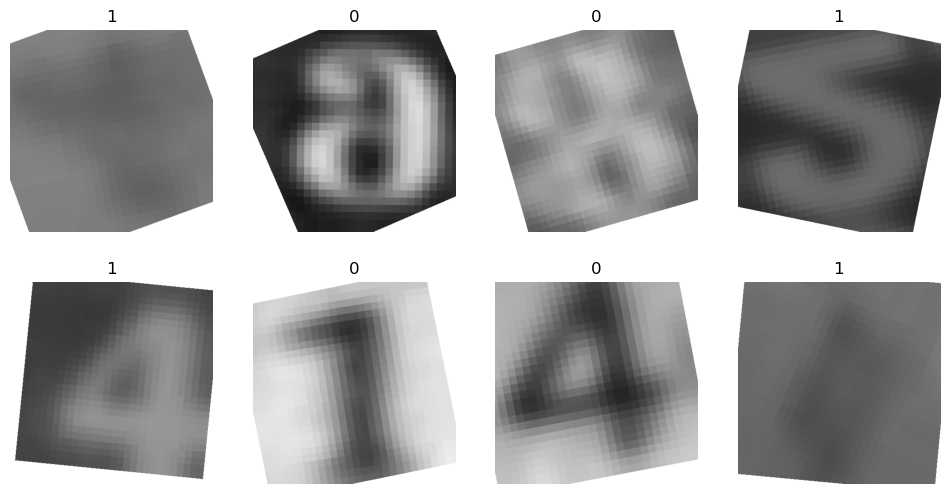

In [21]:
dls = get_data(fold=0)
dls.train.show_batch(max_n=30)

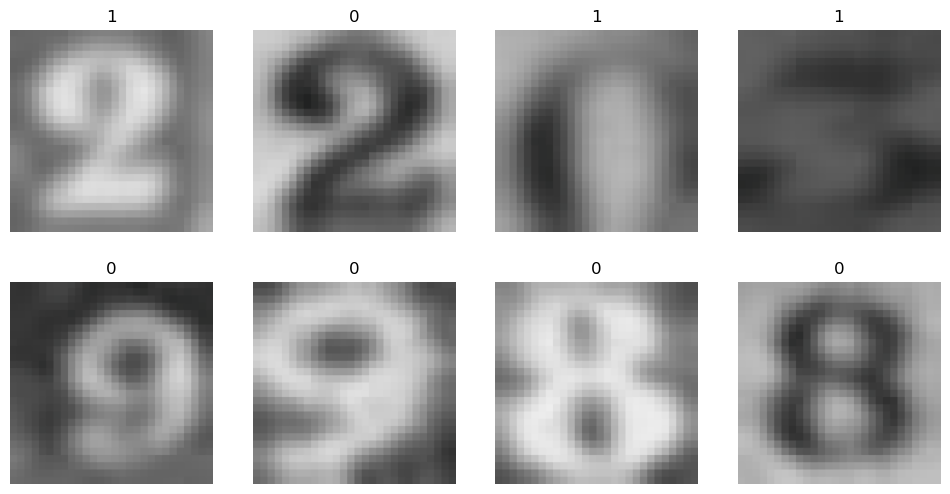

In [22]:
dls.valid.show_batch(max_n=30)

fold1000:   0%|          | 0/10 [00:00<?, ?it/s]

-----------------------
fold 0
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.889024,1.414270,0.589957,01:46


Better model found at epoch 0 with valid_loss value: 1.4142704010009766.


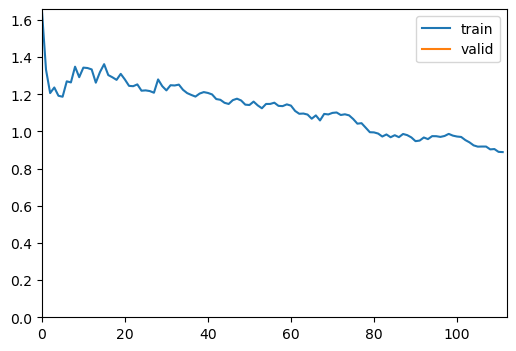

epoch,train_loss,valid_loss,f1_score,time
0,0.575325,0.605279,0.790021,02:05
1,0.616035,0.342970,0.881083,02:05
2,0.354755,1.197397,0.723904,02:05
3,0.368512,0.340400,0.875820,02:05
4,0.268058,0.093059,0.950005,02:05
5,0.277289,0.211794,0.910891,02:05
6,0.227928,0.073260,0.960205,02:05
7,0.144206,0.040109,0.990036,02:05
8,0.128163,0.063546,0.970192,02:05
9,0.131527,0.066100,0.970192,02:05


Better model found at epoch 0 with valid_loss value: 0.6052793264389038.


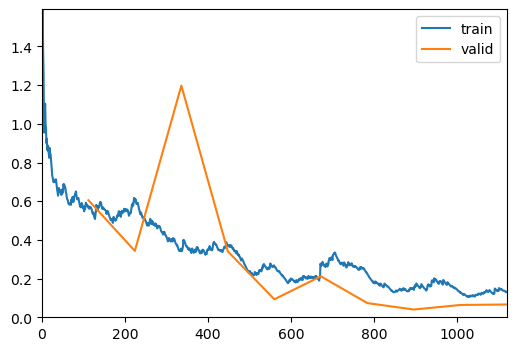

Better model found at epoch 1 with valid_loss value: 0.34297001361846924.
Better model found at epoch 3 with valid_loss value: 0.3404002785682678.
Better model found at epoch 4 with valid_loss value: 0.09305854886770248.
Better model found at epoch 6 with valid_loss value: 0.07326013594865799.
Better model found at epoch 7 with valid_loss value: 0.04010885953903198.


[0.040101245045661926, 0.9900364999506757]


[0.040120724588632584, 0.9900364999506757]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 96% | 45% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 42% | 23% |
-----------------------
fold 1
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.808274,0.975177,0.673603,01:41


Better model found at epoch 0 with valid_loss value: 0.9751765727996826.


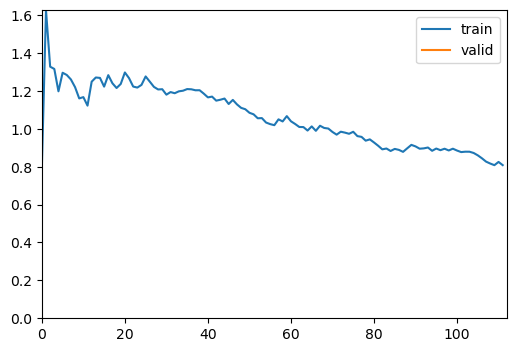

epoch,train_loss,valid_loss,f1_score,time
0,0.541879,0.563040,0.789474,02:05
1,0.490160,0.530307,0.848775,02:05
2,0.364818,0.172405,0.949592,02:05
3,0.397020,0.158226,0.949592,02:05
4,0.273816,0.401622,0.899840,02:05
5,0.276509,0.051506,0.989951,02:05
6,0.222421,0.066280,0.959984,02:05
7,0.166817,0.058997,0.979928,02:05
8,0.159978,0.056210,0.969925,02:05
9,0.173949,0.066240,0.969925,02:06


Better model found at epoch 0 with valid_loss value: 0.5630402565002441.


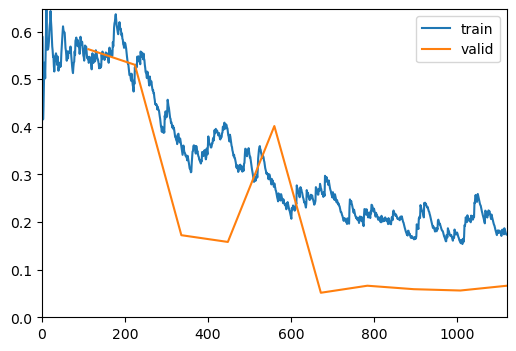

Better model found at epoch 1 with valid_loss value: 0.5303066372871399.
Better model found at epoch 2 with valid_loss value: 0.1724051833152771.
Better model found at epoch 3 with valid_loss value: 0.15822573006153107.
Better model found at epoch 5 with valid_loss value: 0.051506396383047104.


[0.05152056738734245, 0.9899507587177169]


[0.05152913182973862, 0.9899507587177169]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 47% | 54% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 47% | 34% |
-----------------------
fold 2
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.879178,0.624178,0.715909,01:42


Better model found at epoch 0 with valid_loss value: 0.6241779923439026.


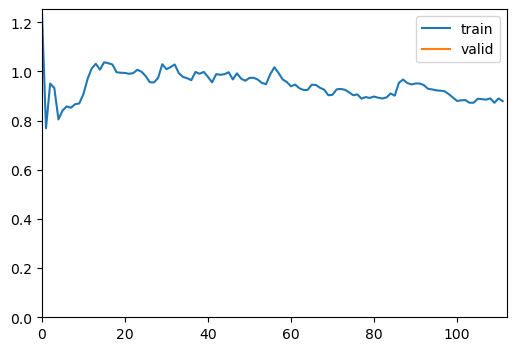

epoch,train_loss,valid_loss,f1_score,time
0,0.610858,0.550531,0.703325,02:05
1,0.486638,0.406799,0.840000,02:05
2,0.434716,0.483834,0.887468,02:06
3,0.355432,0.227507,0.889458,02:06
4,0.320774,0.176404,0.919968,02:06
5,0.264128,0.166471,0.959742,02:06
6,0.198541,0.114715,0.959742,02:06
7,0.159065,0.233162,0.949592,02:06
8,0.231462,0.144970,0.959742,02:06
9,0.140308,0.138944,0.959742,02:06


Better model found at epoch 0 with valid_loss value: 0.5505311489105225.


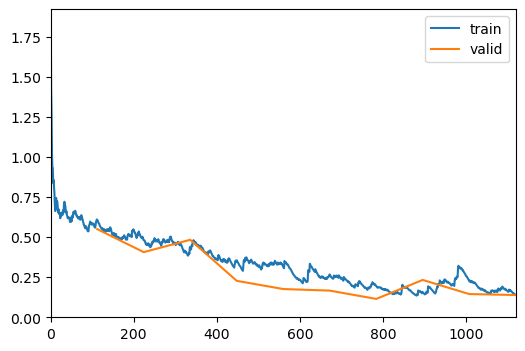

Better model found at epoch 1 with valid_loss value: 0.4067988097667694.
Better model found at epoch 3 with valid_loss value: 0.22750705480575562.
Better model found at epoch 4 with valid_loss value: 0.17640404403209686.
Better model found at epoch 5 with valid_loss value: 0.16647079586982727.
Better model found at epoch 6 with valid_loss value: 0.11471516638994217.


[0.11469771713018417, 0.9597423510466989]


[0.11471585184335709, 0.9597423510466989]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 56% | 62% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 72% | 23% |
-----------------------
fold 3
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.798674,0.930242,0.638699,01:42


Better model found at epoch 0 with valid_loss value: 0.9302417635917664.


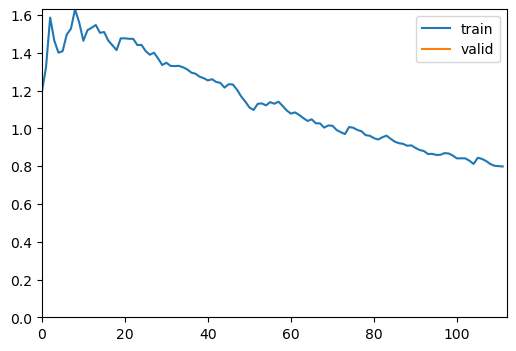

epoch,train_loss,valid_loss,f1_score,time
0,0.560717,0.832068,0.733169,02:06
1,0.478989,0.645217,0.808448,02:06
2,0.476194,0.248530,0.889989,02:06
3,0.368154,0.058080,0.969852,02:06
4,0.266005,0.105225,0.969633,02:06
5,0.273141,0.036455,0.989918,02:06
6,0.175502,0.094964,0.949140,02:06
7,0.164602,0.068625,0.959416,02:06
8,0.166226,0.032752,0.989918,02:06
9,0.167607,0.052853,0.969633,02:06


Better model found at epoch 0 with valid_loss value: 0.8320680260658264.


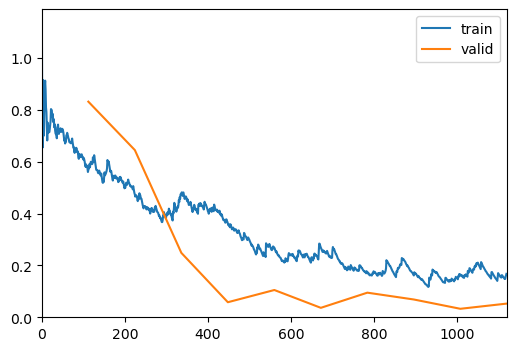

Better model found at epoch 1 with valid_loss value: 0.6452167630195618.
Better model found at epoch 2 with valid_loss value: 0.24853047728538513.
Better model found at epoch 3 with valid_loss value: 0.05807977542281151.
Better model found at epoch 5 with valid_loss value: 0.03645491972565651.
Better model found at epoch 8 with valid_loss value: 0.03275184705853462.


[0.03274305909872055, 0.9899183385421917]


[0.032740648835897446, 0.9899183385421917]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 60% | 54% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 66% | 34% |
-----------------------
fold 4
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.908217,1.290327,0.590663,01:42


Better model found at epoch 0 with valid_loss value: 1.2903265953063965.


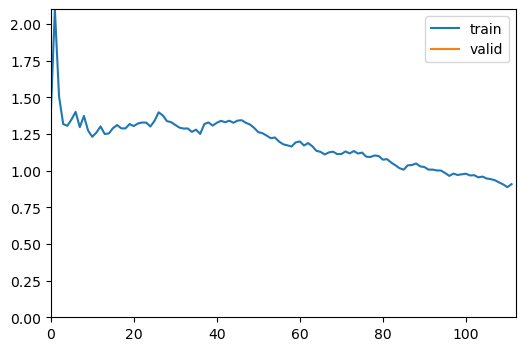

epoch,train_loss,valid_loss,f1_score,time
0,0.584239,1.104970,0.607227,02:06
1,0.572003,0.681893,0.733333,02:06
2,0.438565,0.124384,0.959984,02:06
3,0.451105,0.239717,0.899639,02:06
4,0.356629,0.082146,0.960000,02:06
5,0.187129,0.184705,0.959936,02:06
6,0.202597,0.063673,0.969997,02:06
7,0.118488,0.024499,0.989999,02:06
8,0.146435,0.038920,0.979992,02:06
9,0.154709,0.028053,0.989999,02:06


Better model found at epoch 0 with valid_loss value: 1.1049697399139404.


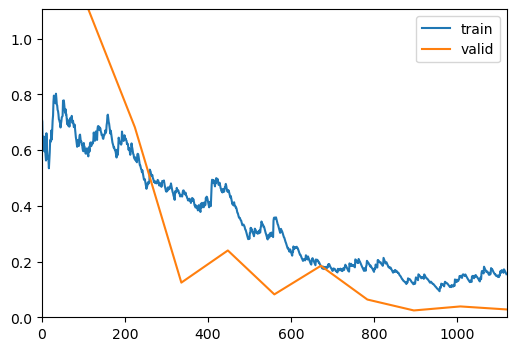

Better model found at epoch 1 with valid_loss value: 0.6818932890892029.
Better model found at epoch 2 with valid_loss value: 0.12438356131315231.
Better model found at epoch 4 with valid_loss value: 0.08214627951383591.
Better model found at epoch 6 with valid_loss value: 0.06367303431034088.
Better model found at epoch 7 with valid_loss value: 0.02449936605989933.


[0.024486513808369637, 0.98999899989999]


[0.024498434737324715, 0.98999899989999]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 94% | 62% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 34% | 44% |
-----------------------
fold 5
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.918196,2.910027,0.368626,01:42


Better model found at epoch 0 with valid_loss value: 2.910026788711548.


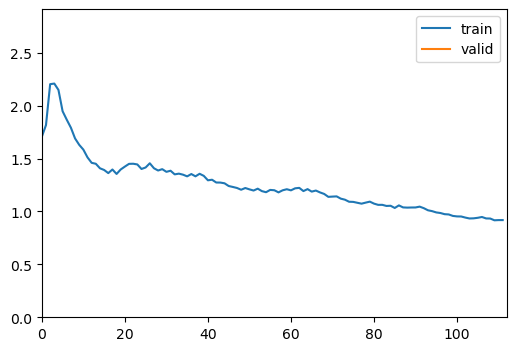

epoch,train_loss,valid_loss,f1_score,time
0,0.642341,1.058609,0.626374,02:06
1,0.530705,0.241868,0.899960,02:06
2,0.425534,0.282192,0.879808,02:06
3,0.390944,0.309467,0.889458,02:06
4,0.257940,0.271442,0.909774,02:06
5,0.221000,0.314029,0.919872,02:06
6,0.171827,0.158231,0.949995,02:06
7,0.240166,0.151640,0.969997,02:06
8,0.184038,0.299936,0.909774,02:06
9,0.142360,0.127790,0.969997,02:06


Better model found at epoch 0 with valid_loss value: 1.0586090087890625.


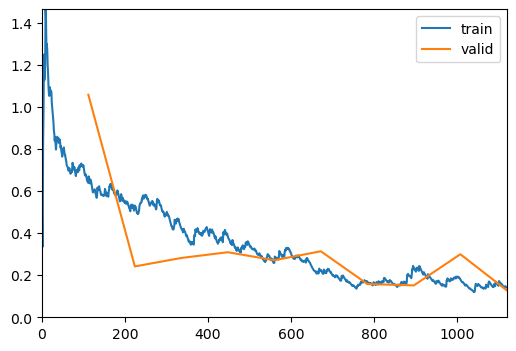

Better model found at epoch 1 with valid_loss value: 0.24186758697032928.
Better model found at epoch 6 with valid_loss value: 0.15823149681091309.
Better model found at epoch 7 with valid_loss value: 0.15163952112197876.
Better model found at epoch 9 with valid_loss value: 0.12779006361961365.


[0.12778283655643463, 0.96999699969997]


[0.12770916521549225, 0.96999699969997]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 96% | 71% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 91% | 24% |
-----------------------
fold 6
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.976172,2.208332,0.487179,01:42


Better model found at epoch 0 with valid_loss value: 2.208331823348999.


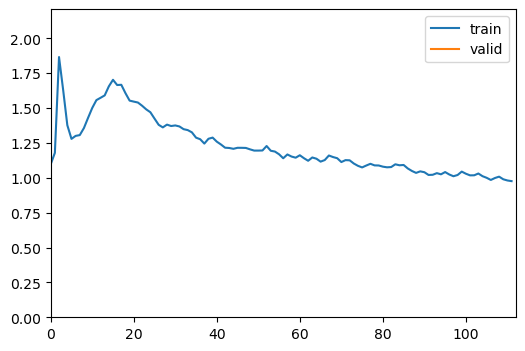

epoch,train_loss,valid_loss,f1_score,time
0,0.559277,0.578924,0.818841,02:06
1,0.497696,0.400491,0.742600,02:06
2,0.443242,0.535993,0.796002,02:06
3,0.368902,0.150448,0.949955,02:06
4,0.432579,0.174548,0.940000,02:06
5,0.260396,0.055691,0.989975,02:06
6,0.234262,0.035168,0.989975,02:06
7,0.198315,0.033178,0.989975,02:06
8,0.175752,0.072522,0.989975,02:06
9,0.184567,0.066610,0.989975,02:06


Better model found at epoch 0 with valid_loss value: 0.5789244771003723.


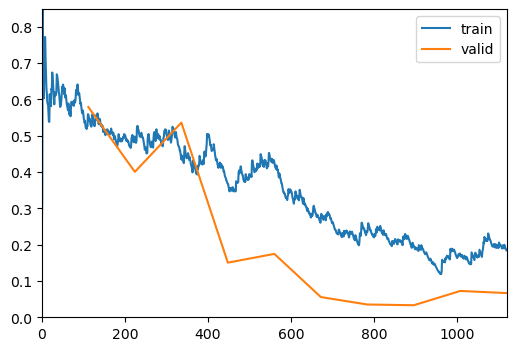

Better model found at epoch 1 with valid_loss value: 0.4004906117916107.
Better model found at epoch 3 with valid_loss value: 0.15044783055782318.
Better model found at epoch 5 with valid_loss value: 0.05569131299853325.
Better model found at epoch 6 with valid_loss value: 0.03516809269785881.
Better model found at epoch 7 with valid_loss value: 0.03317806497216225.


[0.03316308557987213, 0.9899749373433584]


[0.033193934708833694, 0.9899749373433584]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 55% | 53% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 63% | 35% |
-----------------------
fold 7
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.929430,0.854766,0.649685,01:42


Better model found at epoch 0 with valid_loss value: 0.8547662496566772.


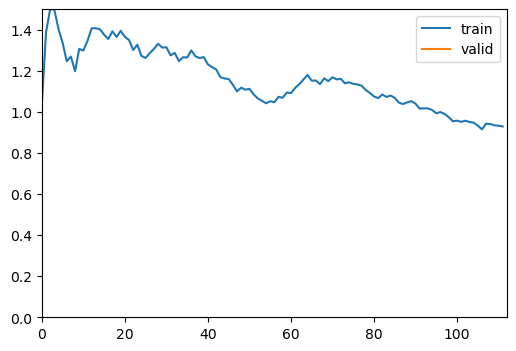

epoch,train_loss,valid_loss,f1_score,time
0,0.642539,1.473418,0.538611,02:06
1,0.582608,0.253126,0.848775,02:06
2,0.456635,0.114060,0.949995,02:06
3,0.420369,0.074533,0.979968,02:06
4,0.321481,0.041357,1.000000,02:06
5,0.280124,0.060145,0.969997,02:06
6,0.211010,0.025019,1.000000,02:06
7,0.185710,0.014139,1.000000,02:06
8,0.135429,0.010964,1.000000,02:06
9,0.151056,0.023230,1.000000,02:06


Better model found at epoch 0 with valid_loss value: 1.4734182357788086.


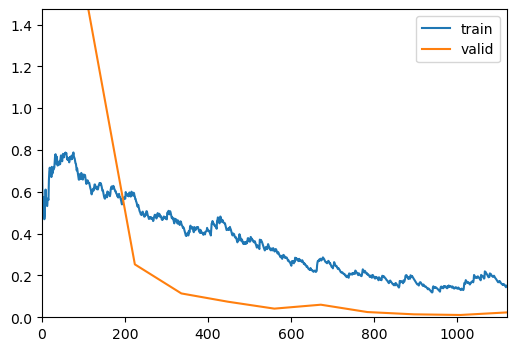

Better model found at epoch 1 with valid_loss value: 0.2531258463859558.
Better model found at epoch 2 with valid_loss value: 0.1140604093670845.
Better model found at epoch 3 with valid_loss value: 0.07453283667564392.
Better model found at epoch 4 with valid_loss value: 0.041356686502695084.
Better model found at epoch 6 with valid_loss value: 0.025019412860274315.
Better model found at epoch 7 with valid_loss value: 0.014138896018266678.
Better model found at epoch 8 with valid_loss value: 0.010964130982756615.


[0.010966366156935692, 1.0]


[0.010973931290209293, 1.0]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 81% | 62% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 38% | 45% |
-----------------------
fold 8
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.834912,0.689707,0.744246,01:42


Better model found at epoch 0 with valid_loss value: 0.689706563949585.


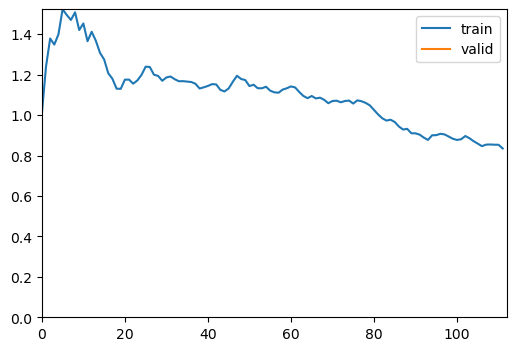

epoch,train_loss,valid_loss,f1_score,time
0,0.609527,0.594687,0.783750,02:06
1,0.415569,0.229793,0.919872,02:06
2,0.333745,0.207468,0.919485,02:06
3,0.321695,0.986502,0.607227,02:06
4,0.253060,0.153276,0.949875,02:06
5,0.216775,0.099926,0.959984,02:06
6,0.268567,0.072373,0.979992,02:06
7,0.171159,0.066031,0.979992,02:06
8,0.173932,0.082451,0.969997,02:06
9,0.162250,0.075377,0.969997,02:06


Better model found at epoch 0 with valid_loss value: 0.5946872234344482.


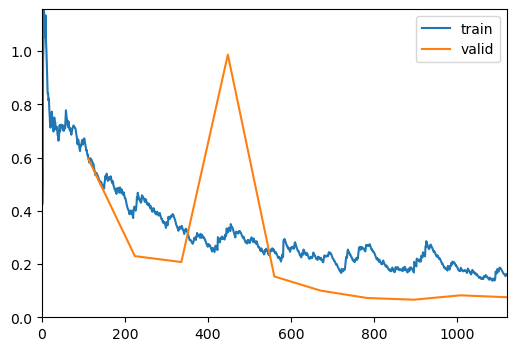

Better model found at epoch 1 with valid_loss value: 0.22979313135147095.
Better model found at epoch 2 with valid_loss value: 0.20746839046478271.
Better model found at epoch 4 with valid_loss value: 0.15327566862106323.
Better model found at epoch 5 with valid_loss value: 0.0999259352684021.
Better model found at epoch 6 with valid_loss value: 0.07237323373556137.
Better model found at epoch 7 with valid_loss value: 0.06603056937456131.


[0.06597805768251419, 0.9799919967987194]


[0.06602038443088531, 0.9799919967987194]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 54% | 71% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 77% | 24% |
-----------------------
fold 9
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.943428,0.941135,0.600906,01:42


Better model found at epoch 0 with valid_loss value: 0.9411348104476929.


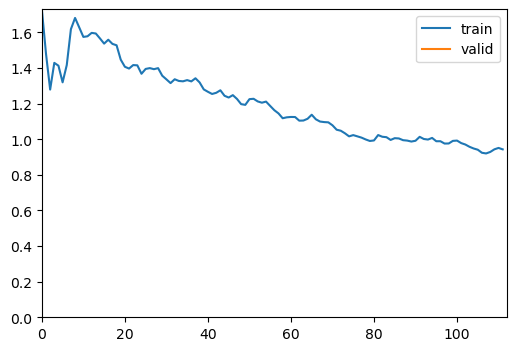

epoch,train_loss,valid_loss,f1_score,time
0,0.595540,0.866612,0.708333,02:06
1,0.572645,0.331336,0.878788,02:06
2,0.417996,0.426304,0.889724,02:06
3,0.344123,0.312682,0.929937,02:06
4,0.322921,0.136831,0.929937,02:06
5,0.192439,0.121875,0.960000,02:06
6,0.138508,0.092800,0.969997,02:06
7,0.148227,0.106452,0.969997,02:06
8,0.129380,0.098075,0.969997,02:06
9,0.120879,0.091180,0.969997,02:06


Better model found at epoch 0 with valid_loss value: 0.8666121959686279.


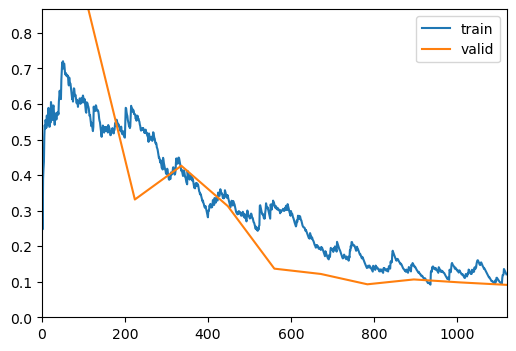

Better model found at epoch 1 with valid_loss value: 0.3313361704349518.
Better model found at epoch 3 with valid_loss value: 0.3126819431781769.
Better model found at epoch 4 with valid_loss value: 0.13683122396469116.
Better model found at epoch 5 with valid_loss value: 0.12187481671571732.
Better model found at epoch 6 with valid_loss value: 0.09280002862215042.
Better model found at epoch 9 with valid_loss value: 0.09118036925792694.


[0.09113912284374237, 0.96999699969997]


[0.0912049412727356, 0.96999699969997]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 96% | 54% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 36% | 34% |


In [23]:
all_preds = []
#cutmix = CutMix(1.)
# mixup = MixUp(1.)
num=10
for i in trange(num,desc=f'fold{i}'):
    print('-----------------------')
    print(f'fold {i}')
    print('-----------------------')
    dls = get_data(i)
#     loss_func_ = CrossEntropyLossFlat(weight=find_weight(i))
    save_cb = SaveModelCallback(monitor='valid_loss',every_epoch=False)
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001 ,patience=5)
    # Create a list of callbacks
    callbacks = [save_cb,GradientAccumulation(n_acc=32)]  #,WandbCallback(log='all')
    
    learn = vision_learner(dls, model_name,pretrained=True,
#                        loss_func=loss_func_,
#                        opt_func=ranger ,
                       path=f'/kaggle/working/{i}/',
                       cbs=[ShowGraphCallback()] ,  #mixup
                       metrics=[F1Score(average='macro')]).to_fp16()
    
    learn.fine_tune(10,freeze_epochs=1,cbs=callbacks)
    
    print(learn.validate())
    learn.load('model')
    print(learn.validate())
    
    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    if i !=num-1:
        del learn
        
    free_gpu_cache()
#     gc.collect()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.94      0.97        51

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



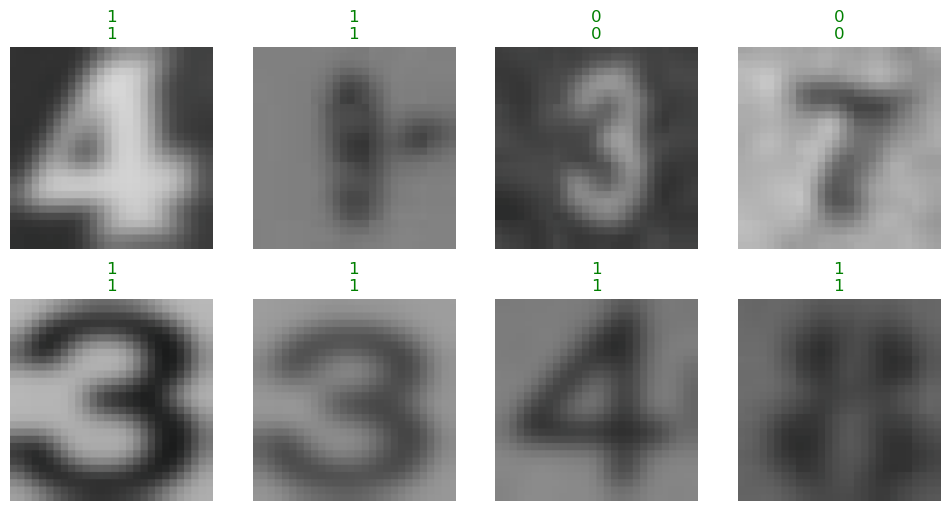

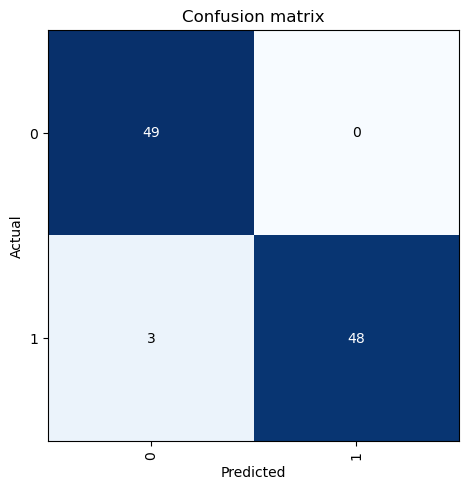

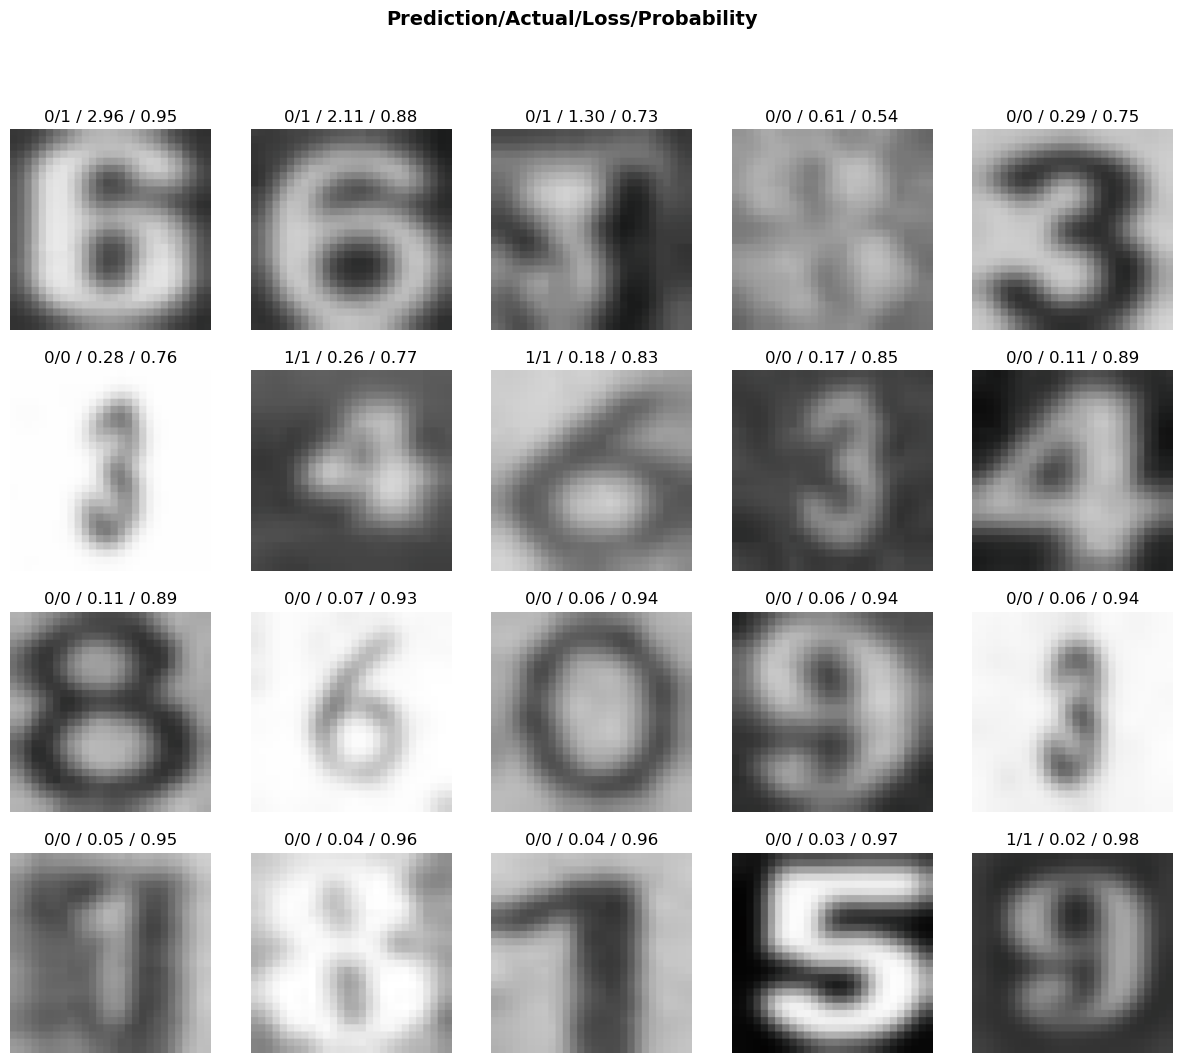

In [24]:
learn.show_results()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()
interp.plot_top_losses(20)

In [25]:
preds = np.mean(np.stack(all_preds), axis=0)
preds = torch.from_numpy(preds)
idxs = preds.argmax(dim=1)
vocab = np.array(dls.vocab)

sub = pd.read_csv('/kaggle/input/hackathon-online-realfakenumbers/sample_submission.csv')
sub.loc[3:,'code'] = vocab[idxs][3:]
sub['code'] =sub['code'].astype('int32')
sub


,img_name,code
0,new_name_0.png,0
1,new_name_1.png,0
2,new_name_2.png,1
3,new_name_3.png,0
4,new_name_4.png,0
...,...,...
1005,new_name_1005.png,0
1006,new_name_1006.png,0
1007,new_name_1007.png,0
1008,new_name_1008.png,0


<Axes: >

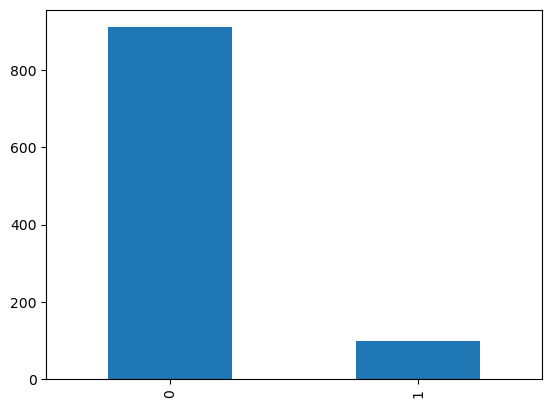

In [26]:
sub['code'].value_counts().plot(kind='bar')

In [27]:
sub.to_csv("submission.csv",index=False)

In [28]:
sub['prob']=preds.max(dim=1).values.tolist()
sub

,img_name,code,prob
0,new_name_0.png,0,0.999934
1,new_name_1.png,0,0.999994
2,new_name_2.png,1,0.848154
3,new_name_3.png,0,0.999981
4,new_name_4.png,0,0.892565
...,...,...,...
1005,new_name_1005.png,0,0.999996
1006,new_name_1006.png,0,0.997309
1007,new_name_1007.png,0,0.999912
1008,new_name_1008.png,0,0.999973


In [29]:
sub.to_csv("submission_pseudo.csv",index=False)

In [30]:
sub['new'] = -1
for i,column in tqdm(sub.iterrows()):
    if column['prob']< 0.9994:
        sub.loc[i,'new'] = 1 
    else :
        sub.loc[i,'new'] = column['code']


0it [00:00, ?it/s]

In [31]:
sub[sub['new']==1]

,img_name,code,prob,new
2,new_name_2.png,1,0.848154,1
4,new_name_4.png,0,0.892565,1
5,new_name_5.png,0,0.973522,1
8,new_name_8.png,0,0.996826,1
10,new_name_10.png,0,0.998073,1
...,...,...,...,...
996,new_name_996.png,1,0.994300,1
1000,new_name_1000.png,0,0.512441,1
1001,new_name_1001.png,0,0.995005,1
1003,new_name_1003.png,0,0.980029,1


In [32]:
sub_final = pd.read_csv('/kaggle/input/hackathon-online-realfakenumbers/sample_submission.csv')
sub_final['code'] = sub['new']
sub_final

,img_name,code
0,new_name_0.png,0
1,new_name_1.png,0
2,new_name_2.png,1
3,new_name_3.png,0
4,new_name_4.png,1
...,...,...
1005,new_name_1005.png,0
1006,new_name_1006.png,1
1007,new_name_1007.png,0
1008,new_name_1008.png,0


In [33]:
sub_final.to_csv("submission_final.csv",index=False)